In [1]:
import numpy as np
np.random.seed(42)
import sys
import cProfile
import h5py
sys.path.insert(0, '../..')
%reload_ext memory_profiler
%reload_ext autoreload
%autoreload 1
import allel
%aimport allel.stats.selection

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/haplotypes/main/hdf5/ag1000g.phase1.ar3.haplotypes.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.haplotypes.3R.h5" (mode r)>

In [4]:
n_variants = 100000
n_samples = 50

In [5]:
h1 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, :n_samples]).to_haplotypes()
h1

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [6]:
h2 = allel.GenotypeArray(callset['3R']['calldata/genotype'][:n_variants, -n_samples:]).to_haplotypes()
h2

,0,1,2,3,4,...,95,96,97,98,99
0,0,0,0,0,0,...,0,0,0,0,0
1,0,0,0,0,0,...,0,0,0,0,0
2,0,0,0,0,0,...,0,0,0,0,0
3,0,0,0,0,0,...,0,0,0,0,0
4,0,0,0,0,0,...,0,0,0,0,0


In [7]:
pos = callset['3R']['variants/POS'][:n_variants]
pos

array([  1252,   1262,   1271, ..., 554764, 554768, 554770], dtype=int32)

In [8]:
ac1 = h1.count_alleles(max_allele=1)
ac2 = h2.count_alleles(max_allele=1)
ac = allel.AlleleCountsArray(ac1 + ac2)
is_seg = ac.is_segregating() & (ac.min(axis=1) > 1)
h1_seg = h1.compress(is_seg, axis=0)
h2_seg = h2.compress(is_seg, axis=0)
pos_seg = pos.compress(is_seg)
ac_seg = ac.compress(is_seg, axis=0)
np.count_nonzero(is_seg)

19897

In [9]:
%%time
score = allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0, include_edges=True)

CPU times: user 5.35 s, sys: 0 ns, total: 5.35 s
Wall time: 5.34 s


In [10]:
score

array([        nan, -0.92126338, -0.93833178, ..., -1.2501573 ,
       -1.27744092,         nan])

In [11]:
np.count_nonzero(np.isnan(score)), np.count_nonzero(~np.isnan(score))

(2, 19895)

In [12]:
np.count_nonzero(np.isinf(score)), np.count_nonzero(~np.isinf(score))

(0, 19897)

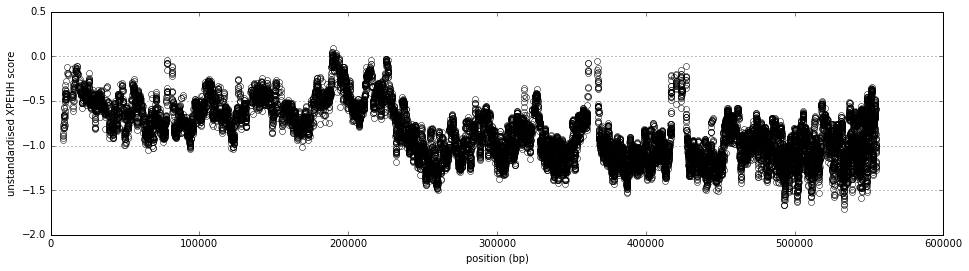

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('unstandardised XPEHH score');

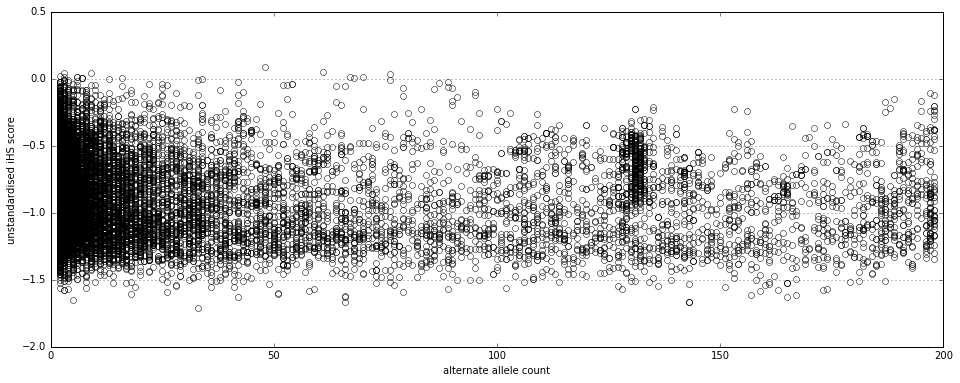

In [14]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('unstandardised iHS score')
plt.grid(axis='y');

In [15]:
import scipy as sp
import scipy.stats

In [16]:
bins = np.arange(n_samples*4 + 2)
mean_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='mean', bins=bins)
std_ihs_by_aac, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score, statistic='std', bins=bins)

In [17]:
bins.shape

(202,)

In [18]:
mean_ihs_by_aac.shape, std_ihs_by_aac.shape

((201,), (201,))

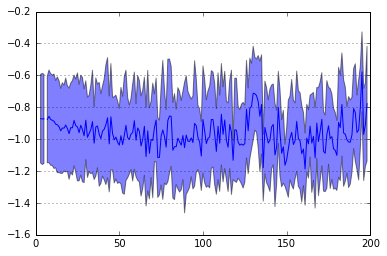

In [19]:
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac - std_ihs_by_aac, 
                 mean_ihs_by_aac + std_ihs_by_aac,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac)
plt.grid(axis='y');

In [20]:
score_centred = np.empty_like(score)
score_normed = np.empty_like(score)

In [21]:
for aac in bins[:-1]:
    loc = ac_seg[:, 1] == aac
    score_centred[loc] = (score[loc] - mean_ihs_by_aac[aac]) 
    score_normed[loc] =  score_centred[loc] / std_ihs_by_aac[aac]

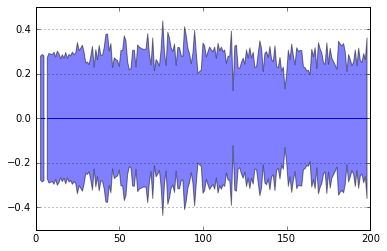

In [22]:
mean_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='mean', bins=bins)
std_ihs_by_aac_centred, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_centred, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_centred - std_ihs_by_aac_centred, 
                 mean_ihs_by_aac_centred + std_ihs_by_aac_centred,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_centred)
plt.grid(axis='y');

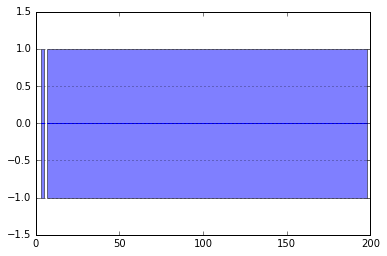

In [23]:
mean_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='mean', bins=bins)
std_ihs_by_aac_normed, _, _ = sp.stats.binned_statistic(ac_seg[:, 1], score_normed, statistic='std', bins=bins)
plt.fill_between(bins[:-1], 
                 mean_ihs_by_aac_normed - std_ihs_by_aac_normed, 
                 mean_ihs_by_aac_normed + std_ihs_by_aac_normed,
                 alpha=.5)
plt.plot(bins[:-1], mean_ihs_by_aac_normed)
plt.grid(axis='y');

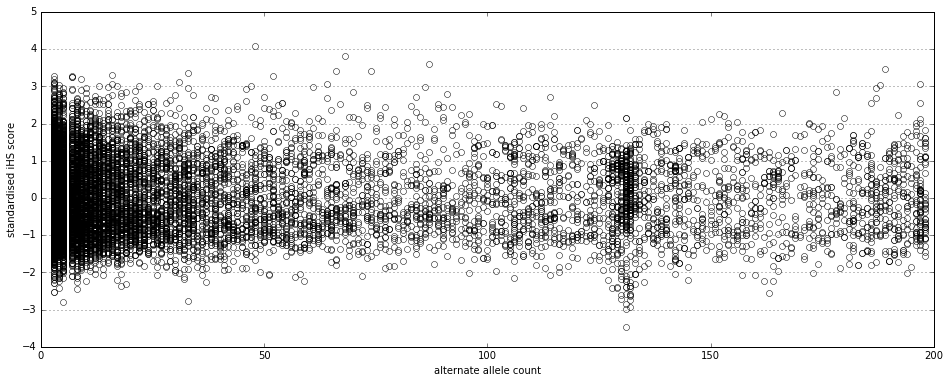

In [24]:
plt.figure(figsize=(16, 6))
plt.plot(ac_seg[:, 1], score_normed, linestyle=' ', marker='o', mfc='none')
plt.xlabel('alternate allele count')
plt.ylabel('standardised iHS score')
plt.grid(axis='y');

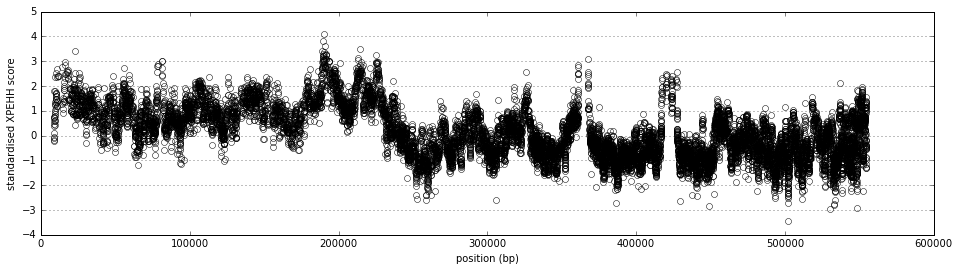

In [25]:
plt.figure(figsize=(16, 4))
plt.plot(pos_seg, score_normed, linestyle=' ', marker='o', mfc='none')
plt.grid(axis='y')
plt.xlabel('position (bp)')
plt.ylabel('standardised XPEHH score');

In [26]:
cProfile.run('allel.stats.xpehh(h1_seg, h2_seg, pos_seg, min_ehh=0, include_edges=True)', sort='time')

         1989840 function calls in 5.923 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    79588    2.957    0.000    5.148    0.000 stats.pyx:456(ssl2ihh)
    79588    1.966    0.000    1.966    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
        4    0.617    0.154    5.922    1.481 stats.pyx:523(ihh_scan_int8)
   238768    0.151    0.000    0.185    0.000 stringsource:985(memoryview_fromslice)
   318372    0.075    0.000    0.075    0.000 stringsource:341(__cinit__)
    79588    0.040    0.000    2.006    0.000 fromnumeric.py:2047(cumsum)
    79604    0.032    0.000    0.088    0.000 stringsource:643(memoryview_cwrapper)
   318372    0.031    0.000    0.031    0.000 stringsource:368(__dealloc__)
   238780    0.018    0.000    0.018    0.000 stringsource:649(memoryview_check)
   238768    0.015    0.000    0.015    0.000 stringsource:962(__dealloc__)
   159180    0.009    0.000    0.009    0.000 stringsource:545(